Here we first do the basic preprocessing to deal with "bad" periods, "broken" meters, missing values. Then we perform some elementary quality controll and clean up artifacts of STL decomposition step.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import STL
from tqdm import tqdm
from joblib import Parallel, delayed

#First Step. Preprocess

The following scrips does 3 things:

1) cut out values after June 2023, this is where during EDA step we observed a lot of unstable behavior with many missing values

2) delete unreliable meters the way we did it during EDA. Basically, if a meter has less then 24% or of time points missing, it gets thrown away.

3) there are still missing values left sparsely distributed throughout the time period. We interpolate with splines first, the perform STL denoising and fill the missing values with new STL predictions.

4) STL step might give negative values, especially where in the original series there are strong peaks. We perform quality control and clip these negative values with a tolerable negative threshold.

In [ ]:
def get_processed_energy_df(energy_file_name = "loureiro_energy.csv"):
    '''Performes initial data cleaning and NaN values filling'''
    #During EDA we've seen that after roughly this date energy plots "go crazy"
    cut_off_date = np.datetime64("2023-06-01")

    energy_df = pd.read_csv(energy_file_name)
    energy_df["Time"] = pd.to_datetime(energy_df["Time"])
    cut_off_mask = energy_df["Time"] <= cut_off_date
    energy_df = energy_df[cut_off_mask]
    energy_df = energy_df.set_index("Time")

    #During EDA we defined that the optimal filtering for meters is to leave only those with at least 76% present values after the first cut off
    portion = 0.76
    cutoff = len(energy_df)*(1-portion)

    missing = energy_df.isna().sum().reset_index()
    missing.columns = ["columns", "num_missing"]
    missing["num_present"] = len(energy_df) - missing['num_missing']

    mask = missing['num_missing'] <= cutoff

    meter_names = missing["columns"][mask].to_list()
    energy_df = energy_df[meter_names]

    # the croped data is then passed to the STL denoiser
    return process_meters(energy_df.copy(), meter_names, n_jobs=-1)

def process_single_meter(args):
    '''Expects a series with NaN mask in form of a tuple (series, isnan_mask). A wrapper around STL decomposition with error catching'''
    series, isnan_mask = args

    try:
        #STL with period 96 - corresponding to measurements every day.
        #seasonal=9 gives a balanced smoothing
        #robust=True helps mitigate the effect of outliers
        stl = STL(series, period=96, seasonal=9, robust=True)
        result = stl.fit()

        #Notice, we do not add residual component where we interpolated with splines originally
        reconstructed = result.trend + result.seasonal + isnan_mask * result.resid

        return reconstructed.values
    except Exception as e:
        print(f"STL failed for series: {e}")
        return series

def process_meters(energy_df, meter_names, n_jobs=-1):
    '''Utilizes cpu cores parallelization for process_single_meter function'''

    #We'll pass this mask for NaN values filling
    isnan_mask = (~energy_df[meter_names].isna()).astype(float)

    #Perform initial interpolation for STL step. The choice of second oreder spline is important
    #As it gives the most stable and robust result
    interpolated = energy_df[meter_names].interpolate(
        method='spline', order=2, limit_direction='both'
    )

    args = [
        (interpolated[meter_name],
         isnan_mask[meter_name])
        for meter_name in meter_names
    ]

    #call cpu parallelixation manager for a minor speedup
    reconstructed_values = Parallel(n_jobs=n_jobs, backend='loky')(
        delayed(process_single_meter)(arg) for arg in tqdm(args, total=len(meter_names))
    )

    energy_df = pd.DataFrame(np.column_stack(reconstructed_values), index=energy_df.index, columns=energy_df.columns)

    return energy_df

In [ ]:
energy_df = get_processed_energy_df()

100%|██████████| 120/120 [34:12<00:00, 17.10s/it]


#Second Step. Quality Control

Here we treat the negative values issue resulting from the previos step.

After we applied the preprocessing step to our data, there is a risk of negative numbers occuring. Let's check it: we plot the number of meters such that at least one value is below the threshold * std. Threshold is marked on the x-axis

100%|██████████| 100/100 [00:00<00:00, 111.22it/s]


Text(0.5, 1.0, 'Negative values thresholding')

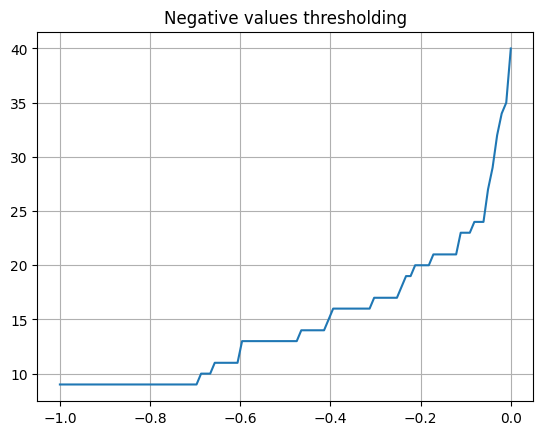

In [ ]:
res = []
test_df = energy_df / energy_df.std()

for threshold in tqdm(np.linspace(0,1, 100)):
    res += [((test_df < -threshold).sum()>0).sum()]

plt.plot(-np.linspace(0,1, 100), np.array(res))
plt.grid()
plt.title("Negative values thresholding (normed by std)")

Let's visually inspect what it correspondes to

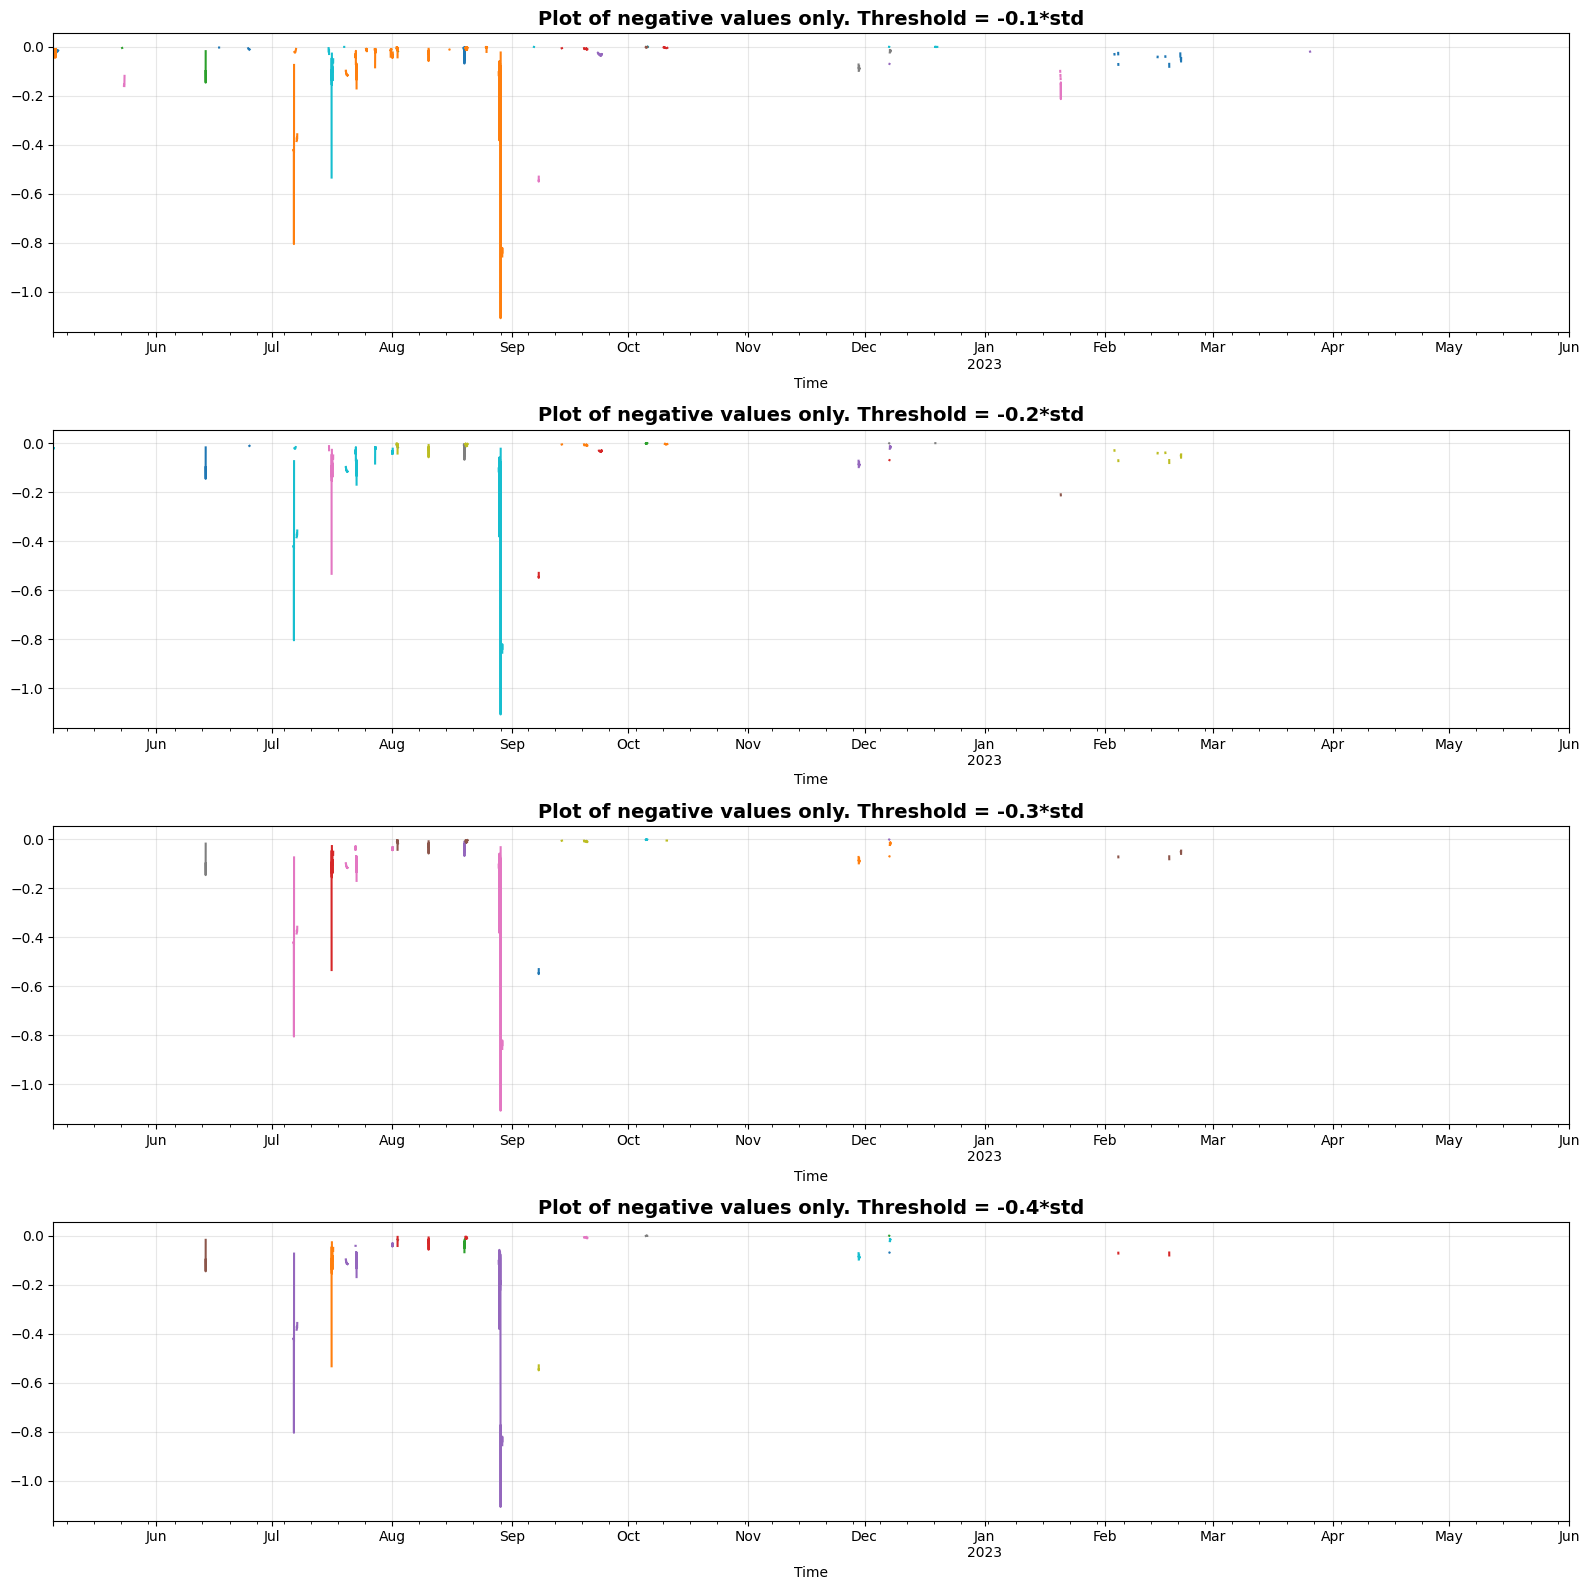

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 16))

nan_energy_df[energy_df.columns[((test_df < -0.1).sum()>0)]][(test_df < -0.1)].plot(ax=ax1)
ax1.set_title('Plot of negative values only. Threshold = -0.1*std', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend().set_visible(False)

nan_energy_df[energy_df.columns[((test_df < -0.2).sum()>0)]][(test_df < -0.2)].plot(ax=ax2)
ax2.set_title('Plot of negative values only. Threshold = -0.2*std', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend().set_visible(False)

nan_energy_df[energy_df.columns[((test_df < -0.3).sum()>0)]][(test_df < -0.3)].plot(ax=ax3)
ax3.set_title('Plot of negative values only. Threshold = -0.3*std', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend().set_visible(False)

nan_energy_df[energy_df.columns[((test_df < -0.4).sum()>0)]][(test_df < -0.4)].plot(ax=ax4)
ax4.set_title('Plot of negative values only. Threshold = -0.4*std', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.legend().set_visible(False)

plt.tight_layout()
plt.show()

We define a function for clipping the values. If the relative negative values go below the threshold too far, we clip them

In [ ]:
energy_df = pd.read_csv('deNaNed_energy.csv')
energy_df["Time"] = pd.to_datetime(energy_df["Time"])
energy_df = energy_df.set_index("Time")

In [ ]:
def clip_energy_values(input_df, threshold=0.1):
    '''Clip valeus that are lower than -threshold*std'''
    df = input_df.copy()

    for name in df.columns:
        df[name] = df[name].clip(lower=-threshold*df[name].std())

    return df

In [ ]:
clipped_df = clip_energy_values(energy_df)

Let's check our thresholding plot once again just to make sure that everything worked as intended

100%|██████████| 100/100 [00:01<00:00, 67.20it/s]


Text(0.5, 1.0, 'Negative values thresholding (normed by std)')

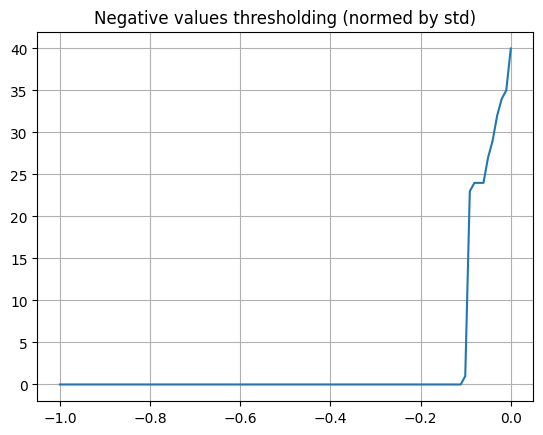

In [ ]:
res = []
test_df = clipped_df / clipped_df.std()

for threshold in tqdm(np.linspace(0,1, 100)):
    res += [((test_df < -threshold).sum()>0).sum()]

plt.plot(-np.linspace(0,1, 100), np.array(res))
plt.grid()
plt.title("Negative values thresholding (normed by std)")

In [ ]:
clipped_df.to_csv("deNaNed_energy.csv")